## Read and extract data from spectra files

In [1]:
# %load kinase_single_well_spectra_experiment

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator)
import matplotlib
from glob import glob

import assaytools

from assaytools import platereader

# 

filenames = ['2017-11-20 15-52-45_plate_1.xml',
            '2017-11-20 16-26-29_plate_1.xml',
            '2017-11-20 16-46-13_plate_1.xml',
            '2017-11-20 17-04-42_plate_1.xml',
            '2017-11-20 17-24-20_plate_1.xml',
            '2017-11-20 17-42-23_plate_1.xml',
            '2017-11-20 18-02-55_plate_1.xml',
            '2017-11-20 18-20-31_plate_1.xml',
            '2017-11-20 18-40-27_plate_1.xml',
            '2017-11-20 18-59-10_plate_1.xml',
            '2017-11-20 19-17-19_plate_1.xml',
            '2017-11-20 19-36-19_plate_1.xml']

datapath = 'infinite_results/spectra'



concentrations = np.array([0.00000000e+00, 8.00000000e-09, 1.74937932e-08, 3.82541000e-08, 
                           8.36511642e-08, 1.82922021e-07, 4.00000000e-07, 8.74689659e-07, 
                           1.91270500e-06, 4.18255821e-06, 9.14610104e-06, 2.00000000e-05,])





reads = list()
nreads = len(filenames)
for read in range(nreads):
    read = platereader.read_icontrol_xml(os.path.join(datapath, filenames[read]))
    reads.append(read)



plate_layout = pd.read_excel('20171120_MI_p38_single_well_plate_layout.xlsx', header=None)
plate_layout = plate_layout.loc[:, 0:1]
plate_layout.columns = ['well', 'name']
if len(list(plate_layout[plate_layout.well == 'A1'].name)[0].split('_')) > 0:
    list(plate_layout[plate_layout.well == 'A1'].name)[0].split('_')

In [2]:
nrows = 8
ncols = 2
index = 0

label = 'ex280_scan_top_gain100'

title = 'Specta Reads at 280nm'
data = np.zeros([nrows, ncols, nreads,65], np.float64) 

for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+5)
        well = row + col
        x_values = list(reads[0][label][well].keys())
        measurements = [list(reads[i][label][well].values()) for i in range(nreads)]
        for i in range(nreads):
            measurements = [x if x != 'OVER' else 0 for x in measurements]
        data[row_index,col_index,:] = np.array(measurements)

## Plot fluorescence spectra for each concentration across all 65 wavelengths

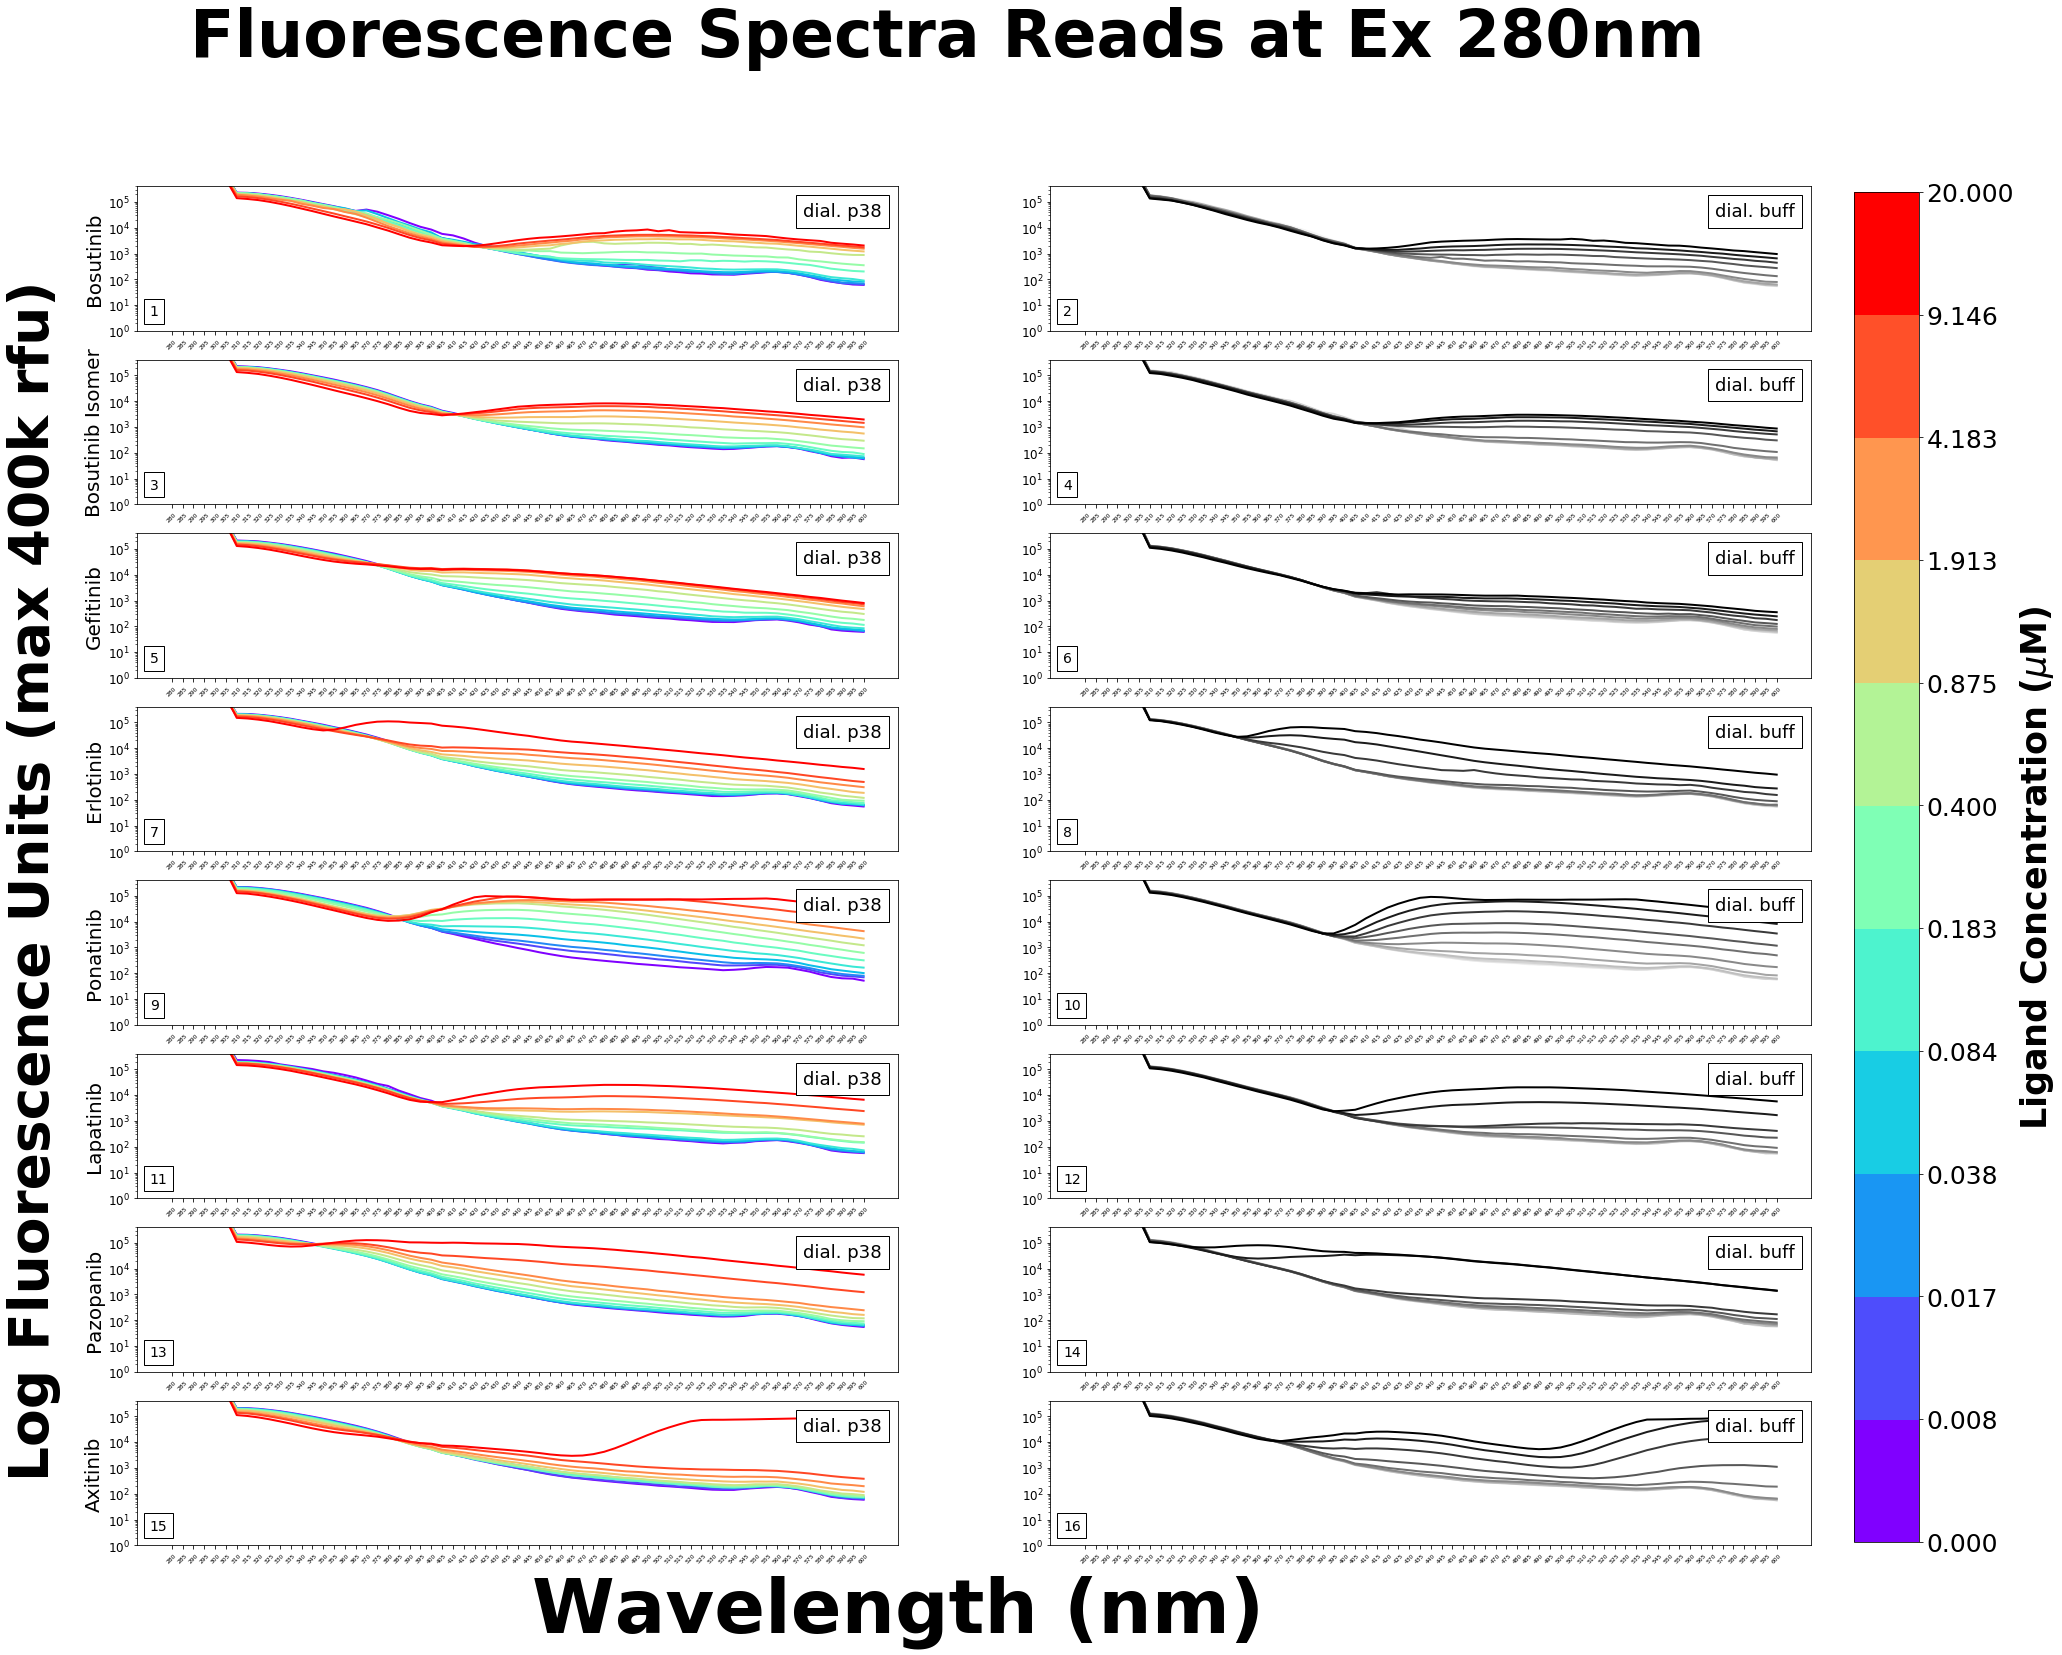

In [3]:
nrows = 8
ncols = 2
index = 0
fig, axes = plt.subplots(nrows, ncols, figsize=[30,25])

label = 'ex280_scan_top_gain100'
title = 'Fluorescence Spectra Reads at Ex 280nm'

xmax = max(list(reads[0][label][well].keys()))
xmin = min(list(reads[0][label][well].keys()))
c = list(concentrations)

for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+5)
        well = row + col
        if len(list(plate_layout[plate_layout.well == well].name)) > 0:
            ax = plt.subplot(nrows,ncols,index+1)
            gray = cm.Greys(np.linspace(0,1,12))
            if plate_layout[plate_layout.well == well].name.any() in ['buffer', 'D300 priming', 'dial. buff']:
                 color=cm.Greys(np.linspace(0,1,12))
            else:
                color=cm.rainbow(np.linspace(0,1,12))
            for read, c in zip(data[row_index,col_index,:,:], color):
                plt.semilogy(x_values, read, c=c, linewidth=2);

            plt.ylim(1, 400000)
            plt.tick_params(axis='y', which='major', labelsize=12)
            plt.tick_params(axis='x', which='major', labelsize=6, labelrotation = 45)

            # label subplots with contents of wells, index #, and axes labels
            if len(list(plate_layout[plate_layout.well == well].name)) > 0:
                anchored_text = AnchoredText('%s' % list(plate_layout[plate_layout.well == well].name)[0].split('_')[0], loc=1, prop=dict(size=18))
                ax.add_artist(anchored_text)
            if index == 15:
                axis = plt.gca()
                plt.xlabel('Wavelength (nm)', fontsize=75, fontweight='bold')
                axis.xaxis.set_label_coords(-0.2,-0.2)   
            if index == 0:
                plt.suptitle(title, fontsize=65, fontweight='bold')
            if index == 15:
                axis = plt.gca()
                plt.ylabel('Log Fluorescence Units (max 400k rfu)', fontsize=55, fontweight='bold')
                axis.yaxis.set_label_coords(-1.3,4.6)
                
            # ligand labels
            if index == 0:
                plt.ylabel('Bosutinib', fontsize=20)
            if index == 2:
                plt.ylabel('Bosutinib Isomer', fontsize=20)
            if index == 4:
                plt.ylabel('Gefitinib', fontsize=20)
            if index == 6:
                plt.ylabel('Erlotinib', fontsize=20)
            if index == 8:
                plt.ylabel('Ponatinib', fontsize=20)
            if index == 10:
                plt.ylabel('Lapatinib', fontsize=20)
            if index == 12:
                plt.ylabel('Pazopanib', fontsize=20)
            if index == 14:
                plt.ylabel('Axitinib', fontsize=20)

            index += 1
            anchored_text2 = AnchoredText('%s' % (index),  loc=3, prop=dict(size=14))
            ax.add_artist(anchored_text2)
            
cax = fig.add_axes([.92, 0.127, 0.03, 0.75])

micro_concentrations = np.multiply(concentrations, 1e6)
norm = matplotlib.colors.BoundaryNorm(micro_concentrations, cm.rainbow.N)
conc_labels = ['{0:.3f}'.format(x) for x in micro_concentrations]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap='rainbow', norm=norm, ticks=micro_concentrations, boundaries=micro_concentrations)
cb.set_label('Ligand Concentration ($\mu$M)', fontsize=35, fontweight='bold')
cb.ax.tick_params(labelsize=25)
cb.ax.set_yticklabels(conc_labels)


fig.savefig('20181212_MI_p38_single_well_spectra_log_y.pdf', bbox_inches='tight', dpi=300)

## Plot fluorescence at ex 280 nm and em 480 nm across concentrations

In [4]:
# get data from other files that measured abs and single wv fluorescence

filenames = ['2017-11-20 15-48-06_plate_1.xml',
            '2017-11-20 16-17-59_plate_1.xml',
            '2017-11-20 16-41-35_plate_1.xml',
            '2017-11-20 16-59-09_plate_1.xml',
            '2017-11-20 17-19-31_plate_1.xml',
            '2017-11-20 17-37-37_plate_1.xml',
            '2017-11-20 17-58-04_plate_1.xml',
            '2017-11-20 18-16-02_plate_1.xml',
            '2017-11-20 18-35-42_plate_1.xml',
            '2017-11-20 18-54-33_plate_1.xml',
            '2017-11-20 19-12-49_plate_1.xml',
            '2017-11-20 19-31-32_plate_1.xml']

datapath = 'infinite_results/single_wv'

reads = list()
nreads = len(filenames)
for read in range(nreads):
    read = platereader.read_icontrol_xml(os.path.join(datapath, filenames[read]))
    reads.append(read)

In [5]:
nrows = 8
ncols = 12
index = 0

label = '280_480_TOP_100'

data = np.zeros([nrows, ncols, nreads], np.float64) 
for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+1)
        well = row + col
        measurements = [(reads[i][label][well]) for i in range(nreads)]
        for i in range(nreads):
            measurements = [x if x != 'OVER' else 0 for x in measurements]
            measurements = [float(i) for i in measurements]
        data[row_index,col_index,:] = np.array(measurements)

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

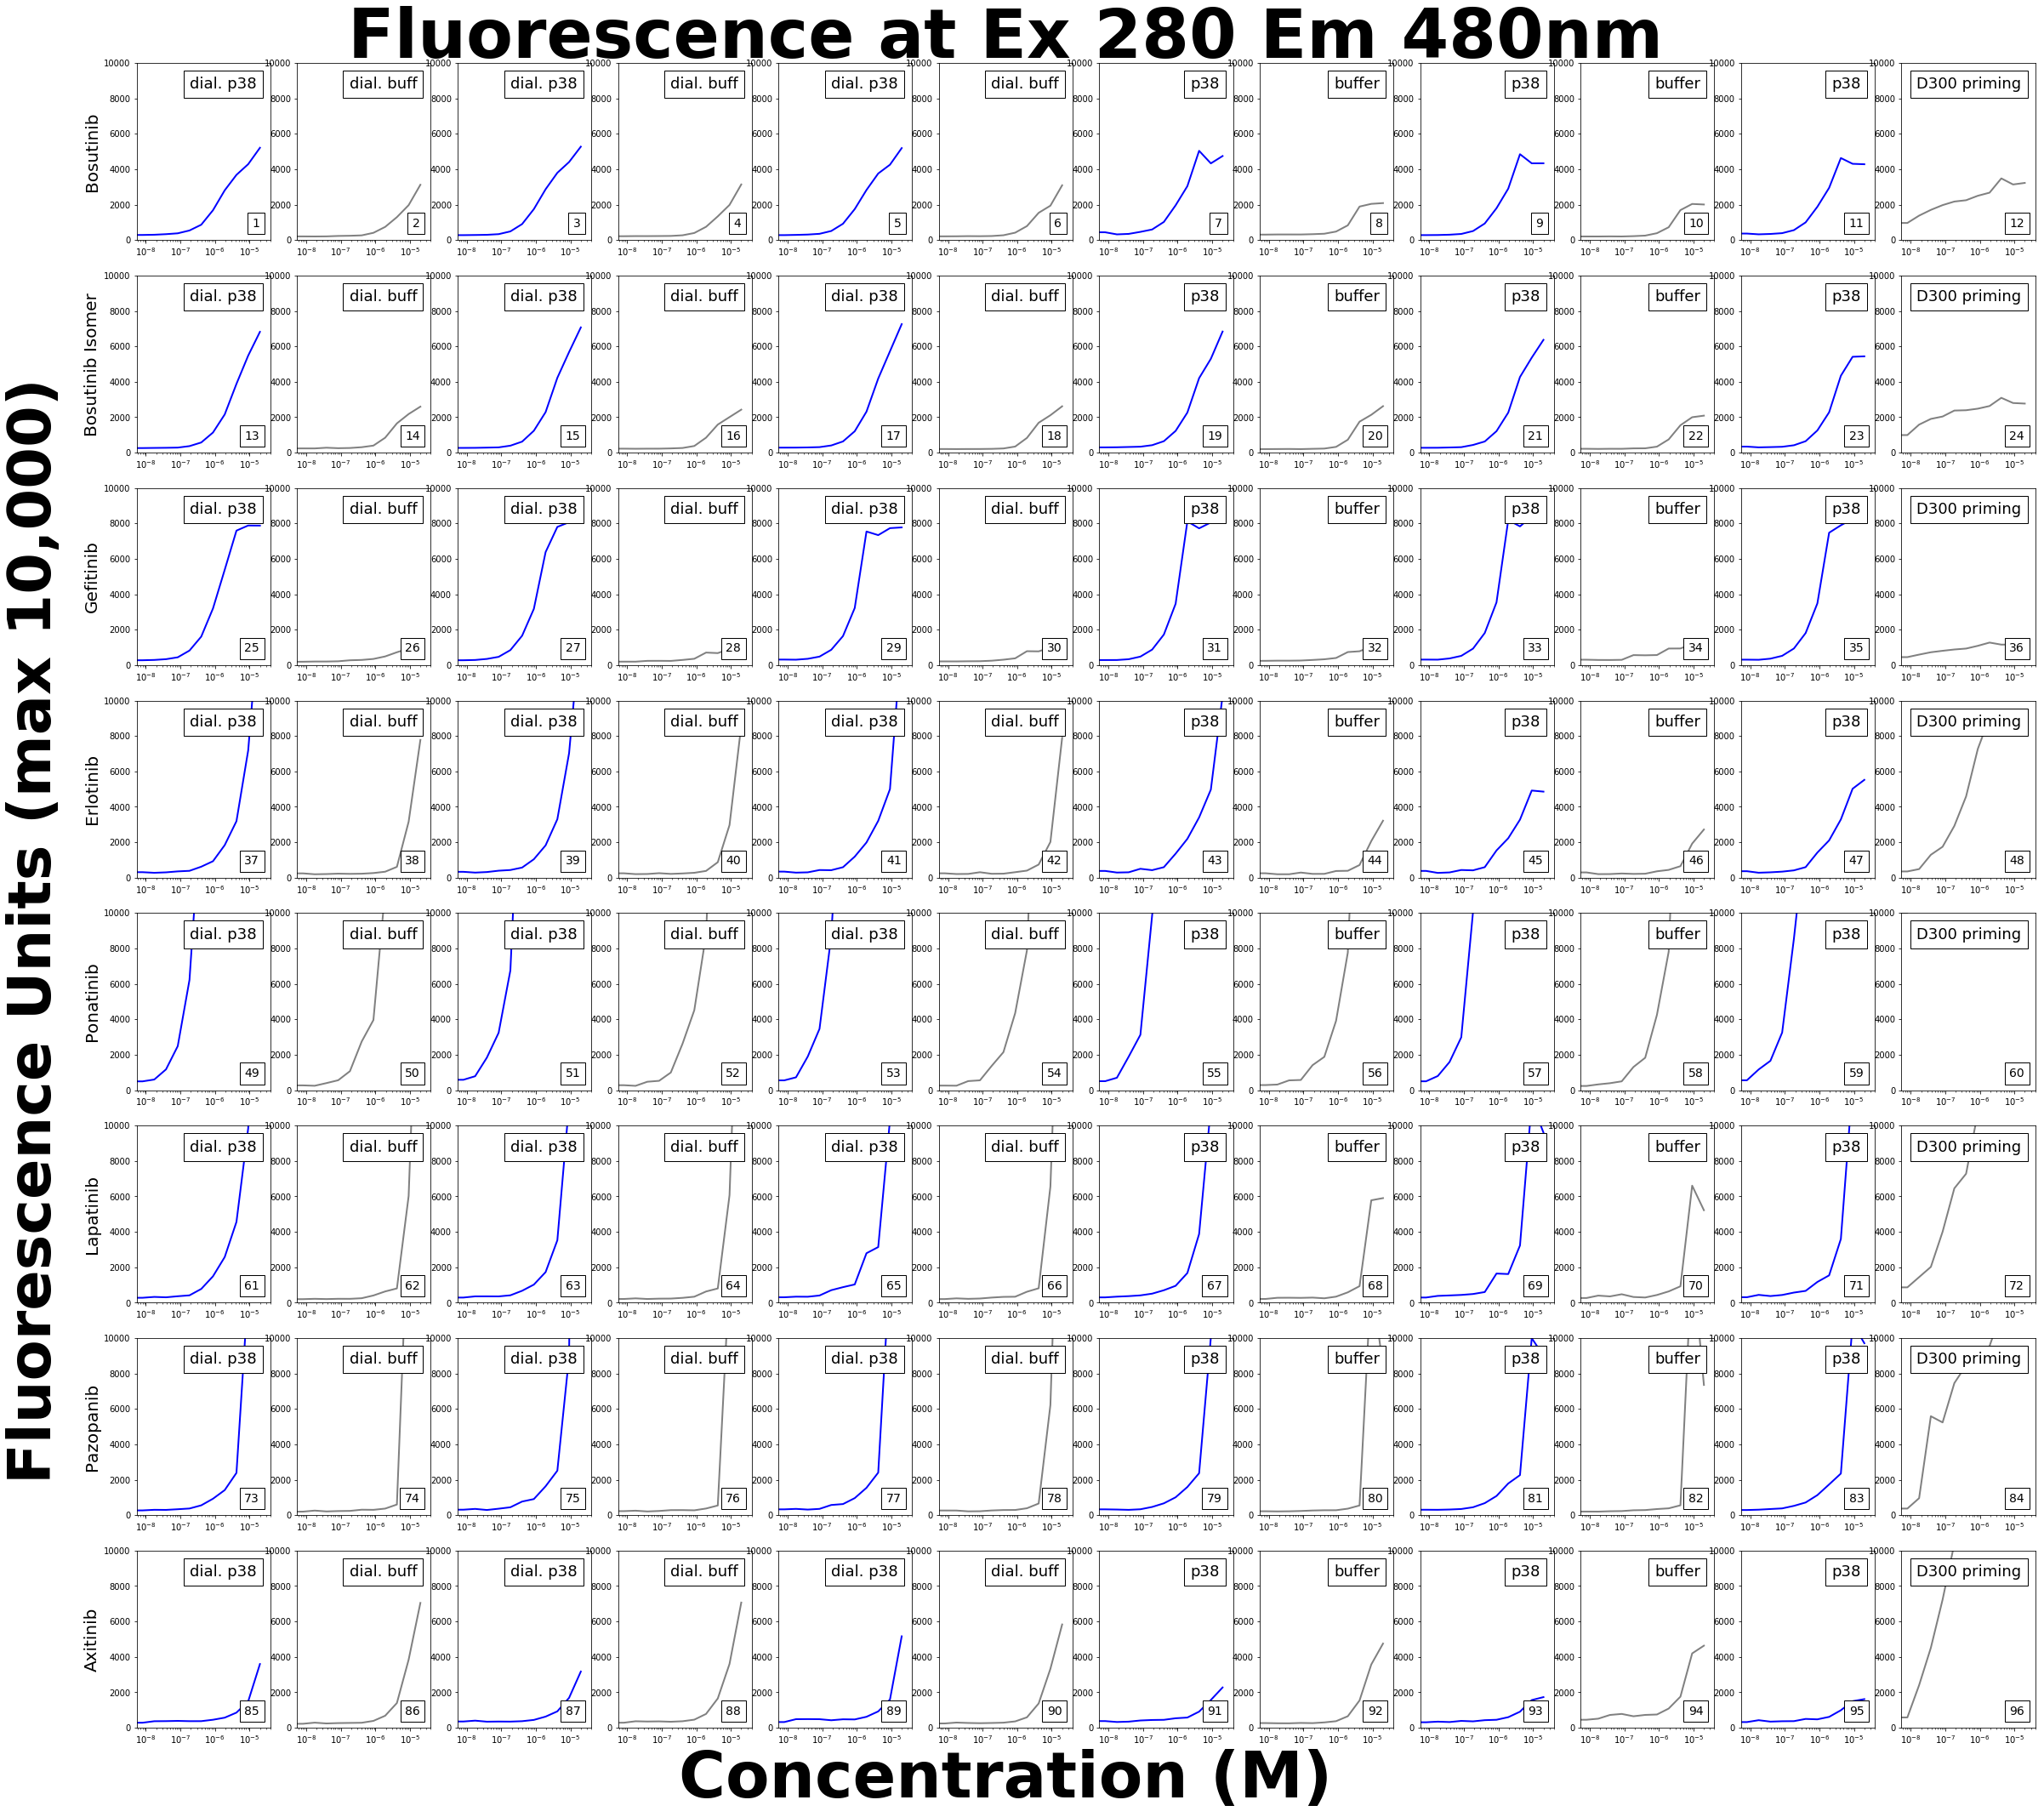

In [6]:
nrows = 8
ncols = 12
index = 0
fig, axes = plt.subplots(nrows, ncols, figsize=[40,36])

label = '280_480_TOP_100'
title = 'Fluorescence at Ex 280 Em 480nm'

x_values = concentrations

for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+1)
        well = row + col
        if len(list(plate_layout[plate_layout.well == well].name)) > 0:
            ax = plt.subplot(nrows,ncols,index+1)
            if plate_layout[plate_layout.well == well].name.any() in ['buffer', 'D300 priming', 'dial. buff']:
                 color='0.5'
            else:
                color='b'
            plt.semilogx(x_values, data[row_index,col_index,:], c=color, linewidth=2);
                
        plt.xlim(0,4e-5)
        plt.ylim(0,10000)
        plt.tick_params(axis='both', which='major', labelsize=10)

        # label subplots with contents of wells and index # 
        if len(list(plate_layout[plate_layout.well == well].name)) > 0:
            anchored_text = AnchoredText('%s' % list(plate_layout[plate_layout.well == well].name)[0].split('_')[0], loc=1, prop=dict(size=18))
            ax.add_artist(anchored_text)
        if index == 89:
            plt.xlabel('Concentration (M)', fontsize=75, fontweight='bold')
        if index == 5:
            plt.title(title, loc='center', fontsize=80, fontweight='bold')
        if index == 85:
            axis = plt.gca()
            plt.ylabel('Fluorescence Units (max 10,000)', fontsize=70, fontweight='bold')
            axis.yaxis.set_label_coords(-1.75,4.5)

        # ligand labels
        if index == 0:
            plt.ylabel('Bosutinib', fontsize=20)
        if index == 12: 
            plt.ylabel('Bosutinib Isomer', fontsize=20)
        if index == 24:
            plt.ylabel('Gefitinib', fontsize=20)
        if index == 36:
            plt.ylabel('Erlotinib', fontsize=20)
        if index == 48:
            plt.ylabel('Ponatinib', fontsize=20)
        if index == 60:
            plt.ylabel('Lapatinib', fontsize=20)
        if index == 72:
            plt.ylabel('Pazopanib', fontsize=20)
        if index == 84:
            plt.ylabel('Axitinib', fontsize=20)
            

        index += 1
        anchored_text2 = AnchoredText('%s' % (index),  loc=4, prop=dict(size=14))
        ax.add_artist(anchored_text2)

            
fig.savefig('20181213_MI_p38_single_well_spectra_fluorescence_480.pdf', bbox_inches='tight', dpi=300)

## Plot absorbance at 280, 350, and 480 nm across concentrations

In [10]:
# need to associate reads with correct well

nrows = 8
ncols = 12
index = 0

label_1 = 'ABS_280'
label_2 = 'ABS_340'
label_3 = 'ABS_480'
    
title = 'Absorbance Reads'
        
data_280 = np.zeros([nrows, ncols, nreads], np.float64)
data_340 = np.zeros([nrows, ncols, nreads], np.float64) 
data_480 = np.zeros([nrows, ncols, nreads], np.float64) 

for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+1)
        well = row + col
        measurements_280 = [(reads[i][label_1][well]) for i in range(nreads)]
        for i in range(nreads):
            measurements_280 = [x if x != 'OVER' else 0 for x in measurements_280]
            measurements_280 = [float(i) for i in measurements_280]
        data_280[row_index,col_index,:] = np.array(measurements_280)
        measurements_340 = [(reads[i][label_2][well]) for i in range(nreads)]
        for i in range(nreads):
            measurements_340 = [x if x != 'OVER' else 0 for x in measurements_340]
            measurements_340 = [float(i) for i in measurements_340]
        data_340[row_index,col_index,:] = np.array(measurements_340)
        measurements_480 = [(reads[i][label_3][well]) for i in range(nreads)]
        for i in range(nreads):
            measurements_480 = [x if x != 'OVER' else 0 for x in measurements_480]
            measurements_480 = [float(i) for i in measurements_480]
        data_480[row_index,col_index,:] = np.array(measurements_480)

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/Applications/miniconda3/envs/assaytools/lib

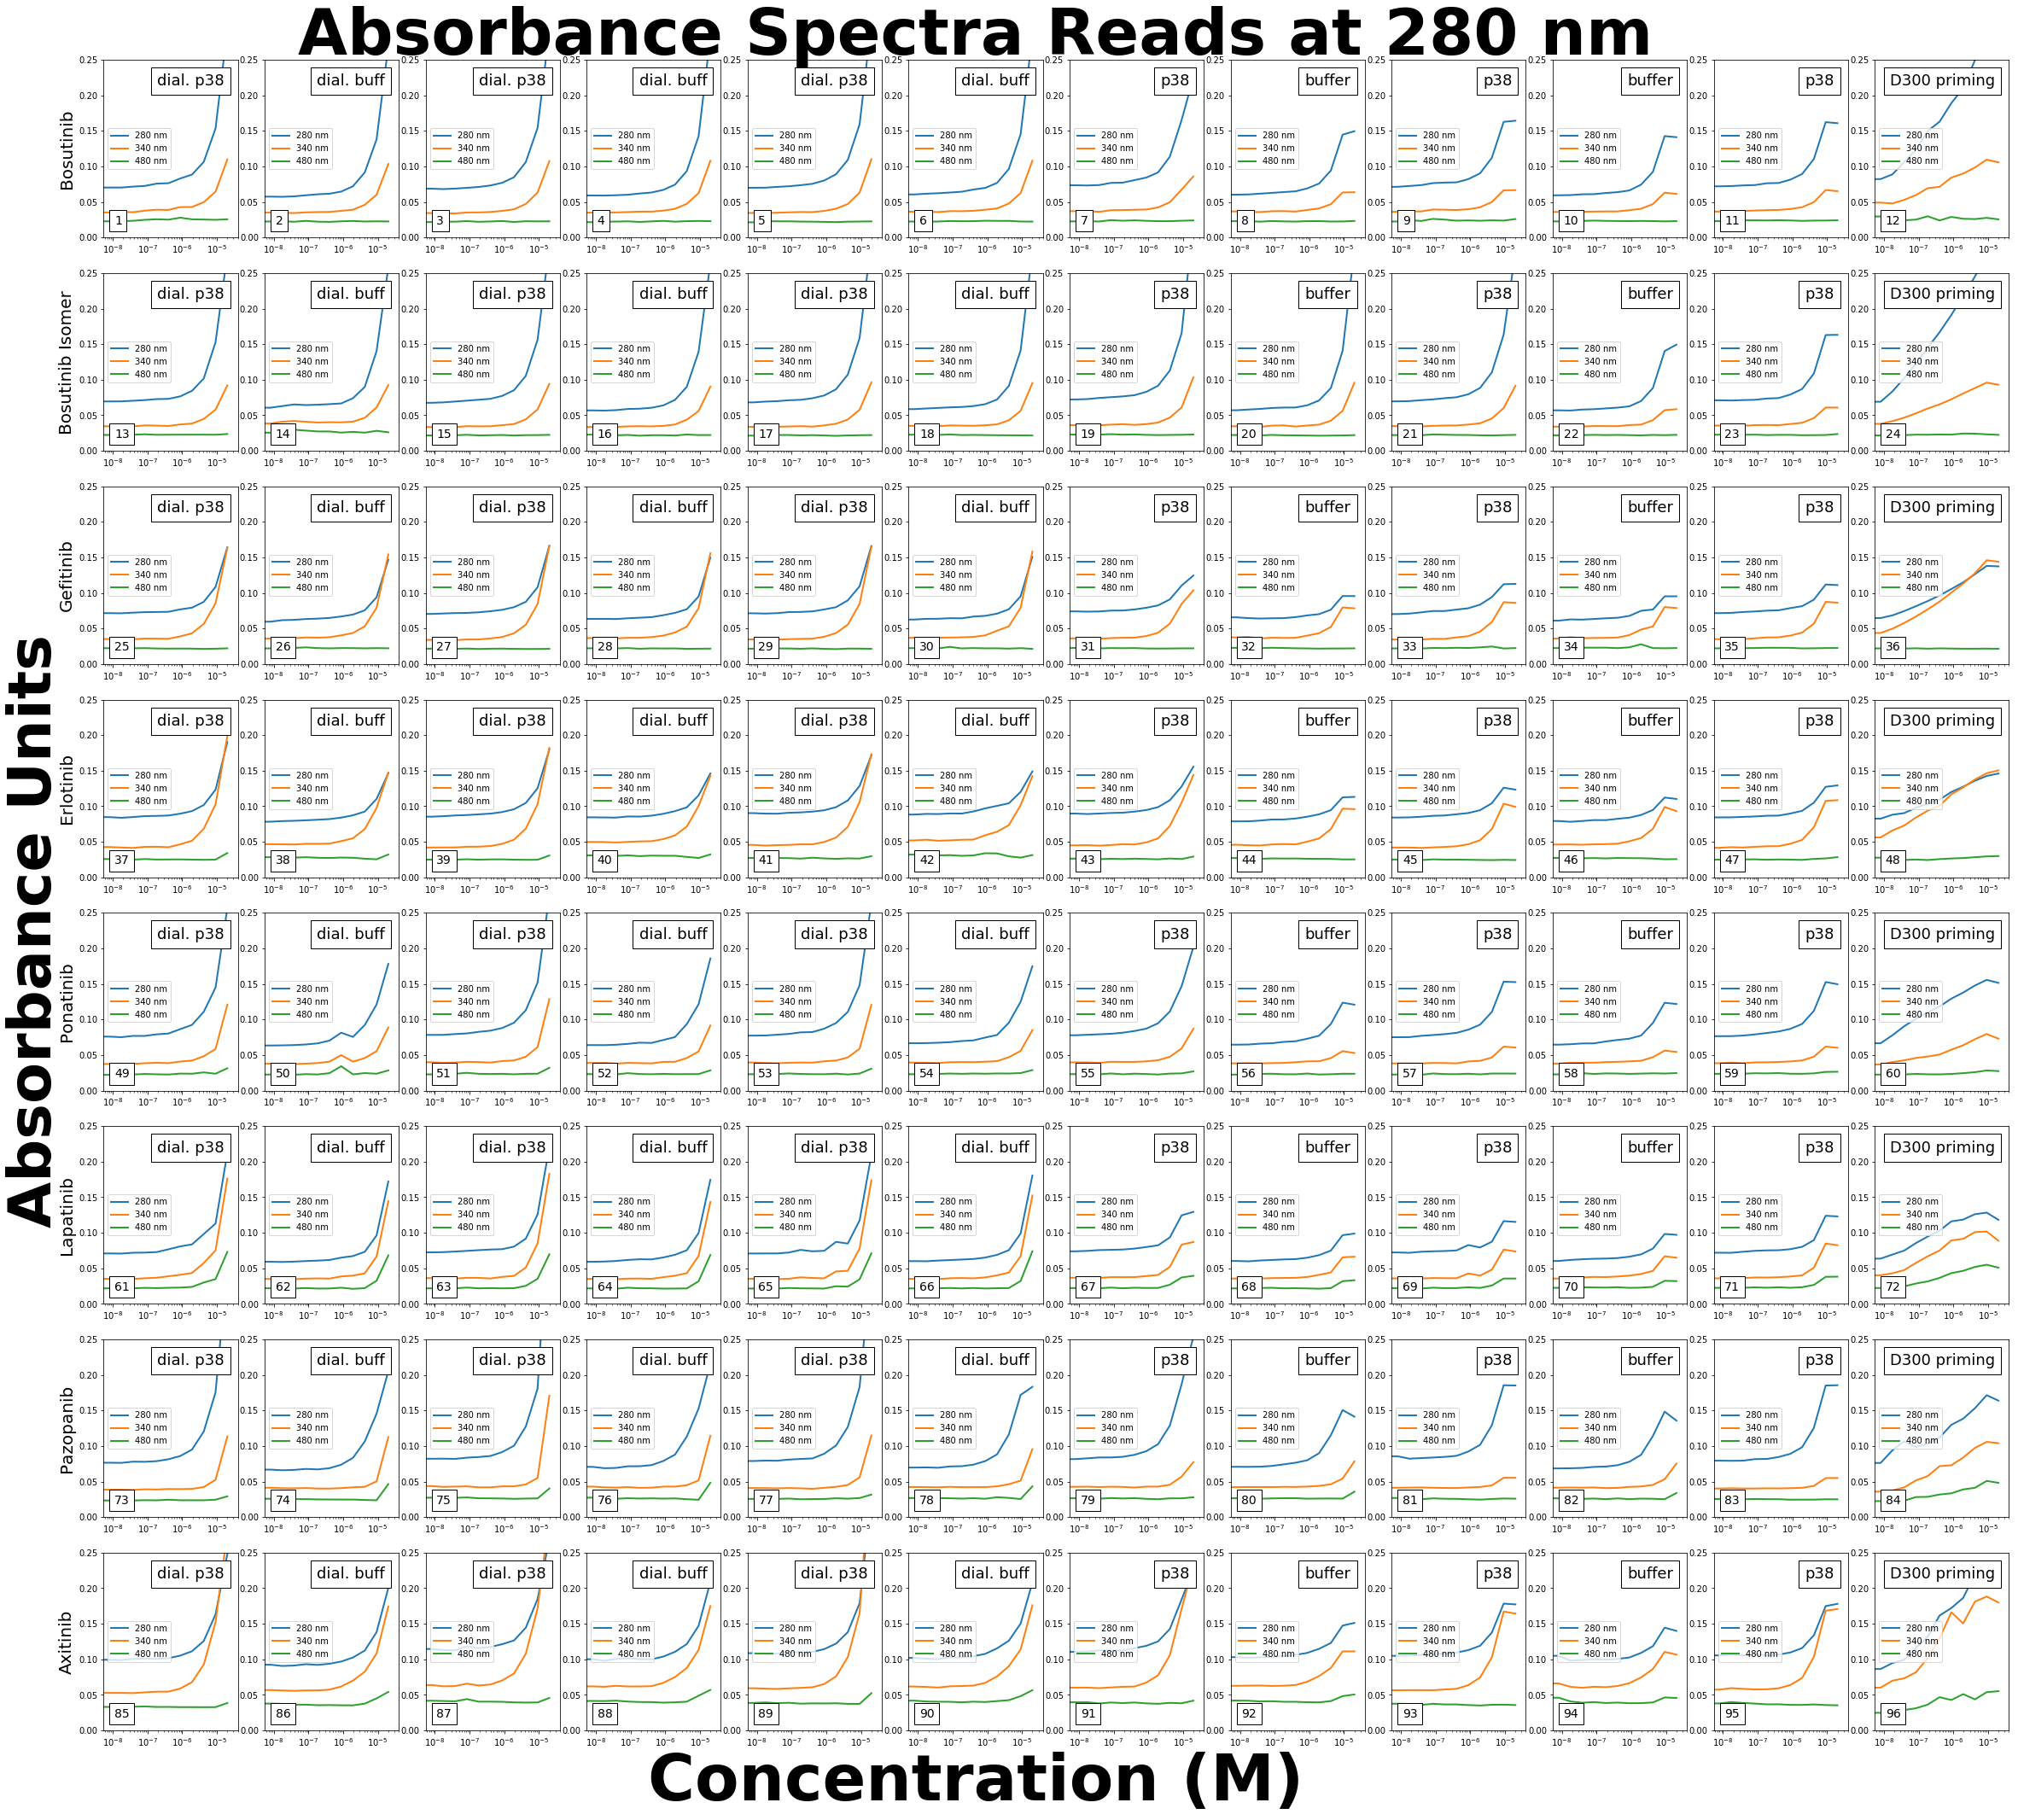

In [12]:
nrows = 8
ncols = 12
index = 0
fig, axes = plt.subplots(nrows, ncols, figsize=[40,36])

title = 'Absorbance Spectra Reads at 280 nm'

for row_index in range(nrows):
    for col_index in range(ncols):
        row = '%c' % (ord('A')+row_index)
        col = '%d' % (col_index+1)
        well = row + col
        if len(list(plate_layout[plate_layout.well == well].name)) > 0:
            ax = plt.subplot(nrows,ncols,index+1)
            plt.semilogx(x_values, data_280[row_index,col_index,:], linewidth=2, label='280 nm')
            plt.semilogx(x_values, data_340[row_index,col_index,:], linewidth=2, label='340 nm')
            plt.semilogx(x_values, data_480[row_index,col_index,:], linewidth=2, label='480 nm')
            
        plt.xlim(0,4e-5)
        plt.ylim(0, 0.25)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.legend(loc='center left')

        # label subplots with contents of wells and index # 
        if len(list(plate_layout[plate_layout.well == well].name)) > 0:
            anchored_text = AnchoredText('%s' % list(plate_layout[plate_layout.well == well].name)[0].split('_')[0], loc=1, prop=dict(size=18))
            ax.add_artist(anchored_text)
        if index == 89:
             plt.xlabel('Concentration (M)', fontsize=75, fontweight='bold')
        if index == 5:
            plt.title(title, loc='center', fontsize=75, fontweight='bold')
        if index == 85:
            axis = plt.gca()
            plt.ylabel('Absorbance Units', fontsize=70, fontweight='bold')
            axis.yaxis.set_label_coords(-1.5,4.5)

        # ligand labels
        if index == 0:
            plt.ylabel('Bosutinib', fontsize=20)
        if index == 12:
            plt.ylabel('Bosutinib Isomer', fontsize=20)
        if index == 24:
            plt.ylabel('Gefitinib', fontsize=20)
        if index == 36:
            plt.ylabel('Erlotinib', fontsize=20)
        if index == 48:
            plt.ylabel('Ponatinib', fontsize=20)
        if index == 60:
            plt.ylabel('Lapatinib', fontsize=20)
        if index == 72:
            plt.ylabel('Pazopanib', fontsize=20)
        if index == 84:
            plt.ylabel('Axitinib', fontsize=20)

        index += 1
        anchored_text2 = AnchoredText('%s' % (index),  loc=3, prop=dict(size=14))
        ax.add_artist(anchored_text2)     
            
fig.savefig('20181213_MI_p38_single_well_absorbance_spectra_280_350_480nm.pdf', bbox_inches='tight', dpi=300)